In [1]:
import os
import pandas as pd
import numpy as np
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
path = "datasets/"

landsat8_train = path + "landsat8_train/train/"
deforest_train = path + "deforestation_train_resized/train/"

In [3]:
'Landsat8_QA_PIXEL_-54.48_-3.33_2013_03_27.tiff'

def get_name_landsat(row, band):
    return f"Landsat8_{band}_{row['lon']:.2f}_{row['lat']:.2f}_{row['date'].year}_{row['date'].month:02d}_{row['date'].day:02d}.tiff"

images = np.array(os.listdir(landsat8_train))
images.sort()

images = images[:int(images.size/9)]

def get_dict(name):
    tokens = name.split("_")
    
    lat = float(tokens[4])
    lon = float(tokens[3])
    
    y = int(tokens[5])
    m = int(tokens[6])
    d = int(tokens[7].split('.')[0])
    
    return {"date": pd.Timestamp(y, m, d), "lat": lat, "lon": lon}

landsat_df = pd.DataFrame(data = [get_dict(i) for i in images])
landsat_df

,date,lat,lon
0,2013-03-27,-3.33,-54.48
1,2013-05-20,-3.33,-54.48
2,2013-06-05,-3.33,-54.48
3,2013-06-21,-3.33,-54.48
4,2013-07-07,-3.33,-54.48
...,...,...,...
233220,2021-08-14,-4.39,-55.20
233221,2021-09-15,-4.39,-55.20
233222,2021-10-01,-4.39,-55.20
233223,2021-10-17,-4.39,-55.20


In [4]:
# Remove the entries with more than 60% of clouds

def load_qa(img):
    # https://www.usgs.gov/landsat-missions/landsat-collection-1-level-1-quality-assessment-band
    img = Image.open(img)
    img = (np.array(img) & 0b11111) == 0
    img = img.astype(np.float32)
    return img

def get_qa_proportion(lr):
    qa = load_qa(landsat8_train + get_name_landsat(lr, "QA_PIXEL"))
    return (qa == 0).mean()

clouds = landsat_df.apply(get_qa_proportion, axis = 1)
landsat_df = landsat_df[clouds < 0.2]

(clouds < 0.2).mean()

0.22460285132382893

In [7]:
# Funções 

def load_labels(img):
    img = Image.open(img)
    img = np.array(img).astype(np.float32) / 256
    return img

def load_image(img):
    img = Image.open(img)
    img = np.array(img).astype(np.float32)

    #img -= 10000
    img /= 65536
    
    return img

def load_qa(img):
    # https://www.usgs.gov/landsat-missions/landsat-collection-1-level-1-quality-assessment-band
    img = Image.open(img)
    img = (np.array(img) & 0b11111) == 0
    img = img.astype(np.float32)
    return img

def get_qa_proportion(lr):
    qa = load_qa(landsat8_train + get_name_landsat(lr, "QA_PIXEL"))
    return (qa == 0).mean()

def get_image_and_qa(lr):
    bands = []
    for band in [ "SR_B1", "SR_B2", "SR_B3", "SR_B4", "SR_B5", "SR_B6", "SR_B7"]:
        name = get_name_landsat(lr, band)
        bands.append(load_image(landsat8_train + name))
    img = np.stack(bands, axis = -1)

    qa = load_qa(landsat8_train + get_name_landsat(lr, "QA_PIXEL"))

    return np.concatenate([img, qa[:, :, None]], axis = -1)

def plot_image(img):
    fig, axes = plt.subplots(1, 8, figsize=(15, 10))
    for i in range(8):
        axes[i].imshow(img[:, :, i], vmin = 0, vmax = 1)
    plt.show()

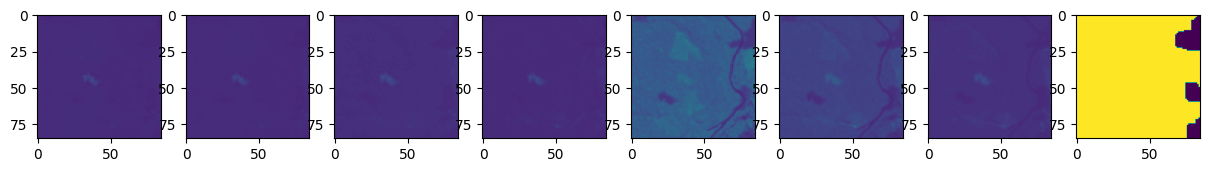

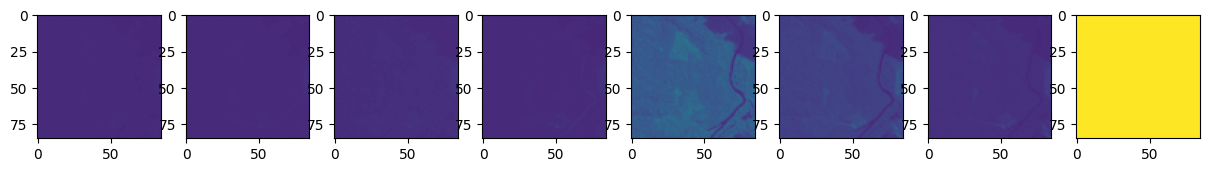

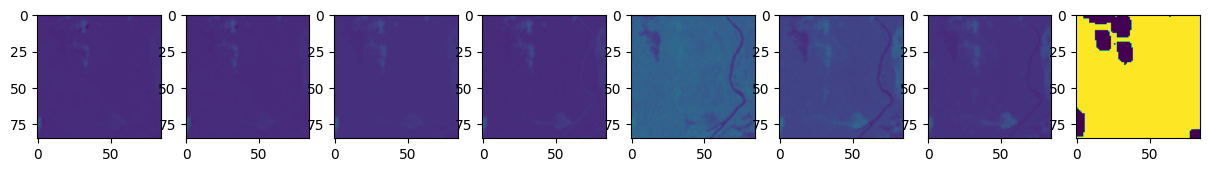

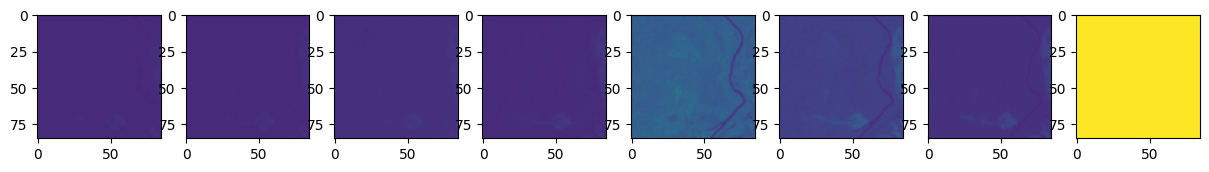

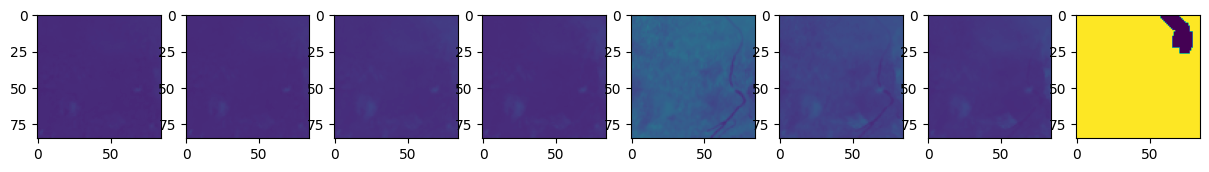

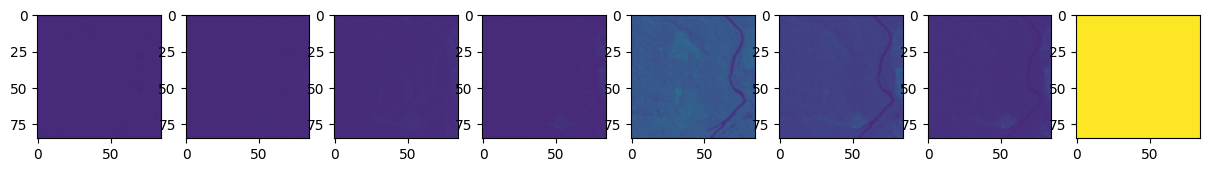

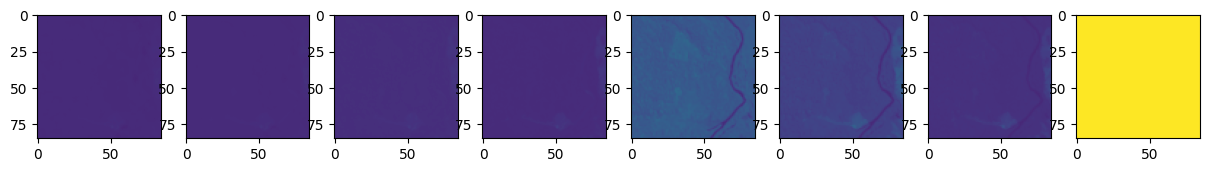

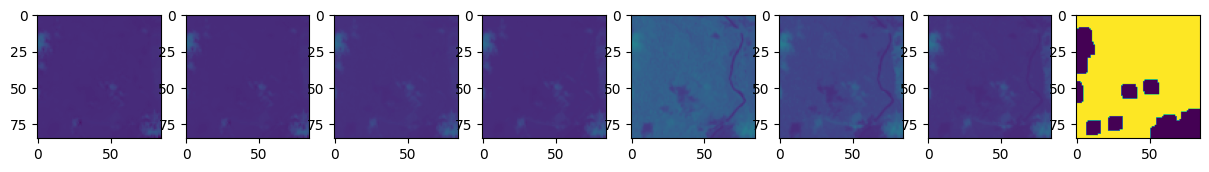

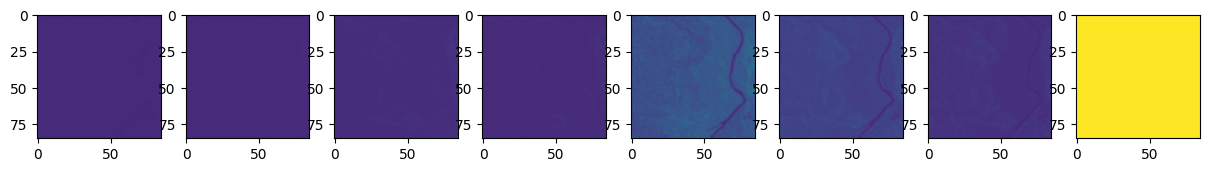

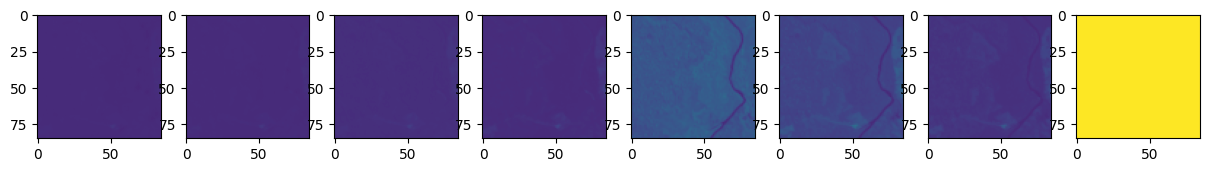

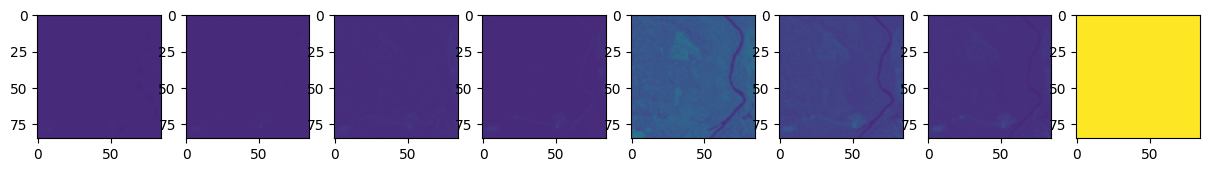

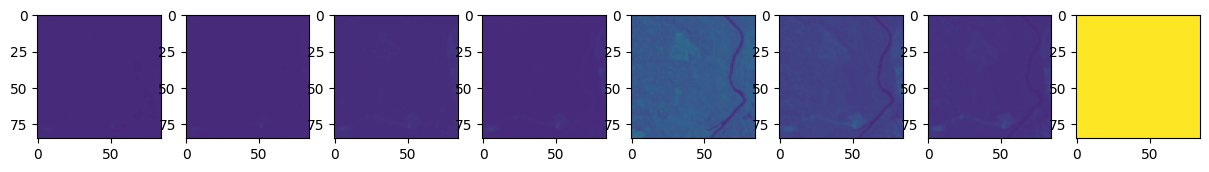

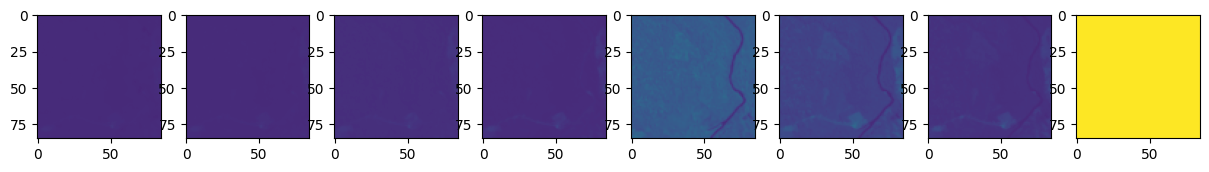

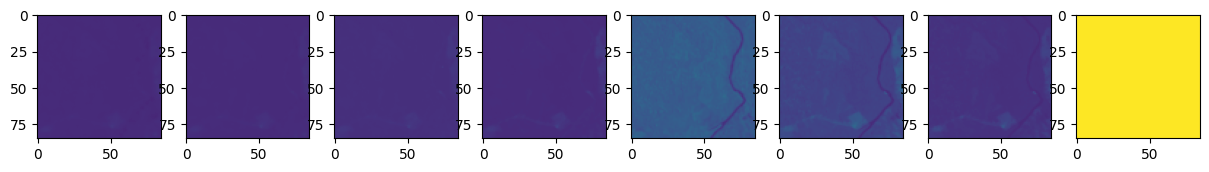

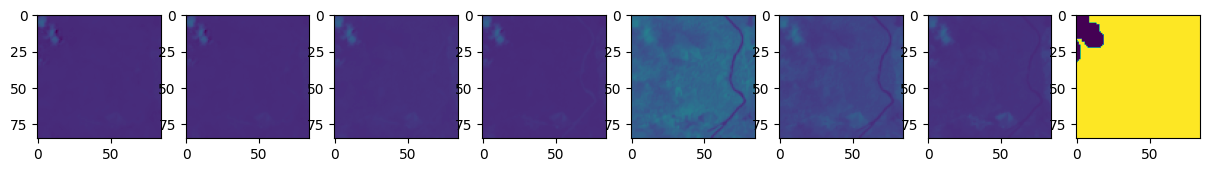

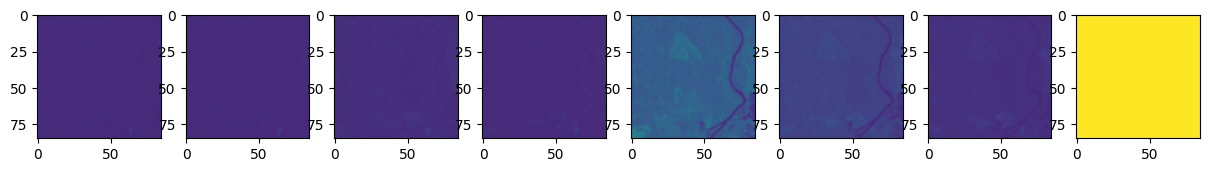

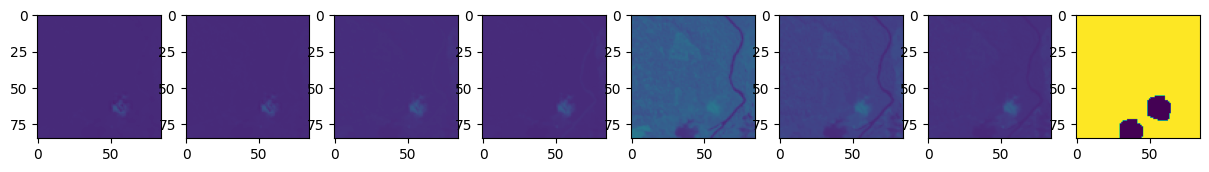

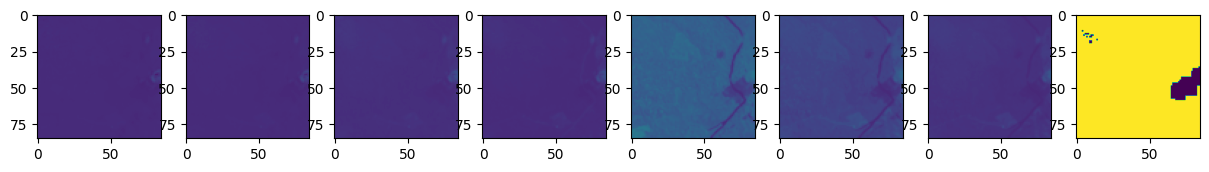

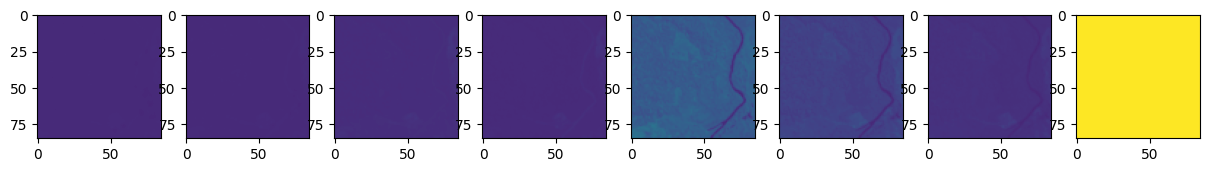

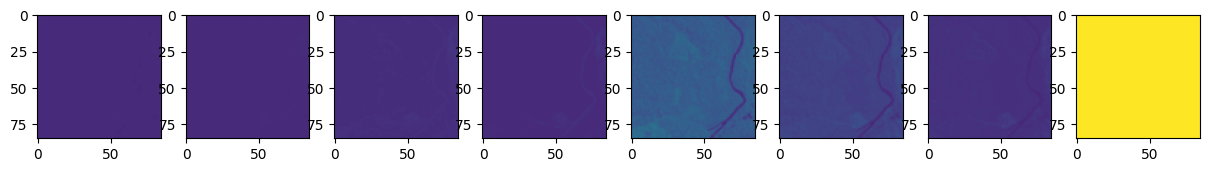

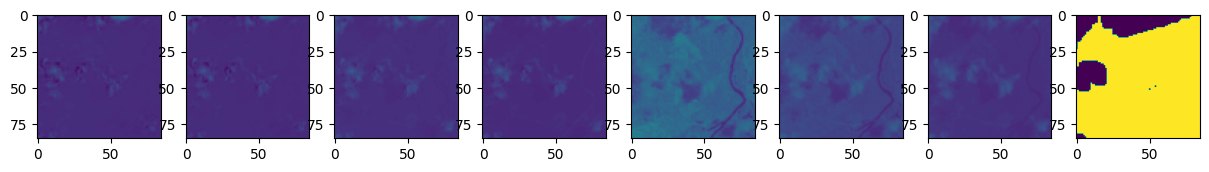

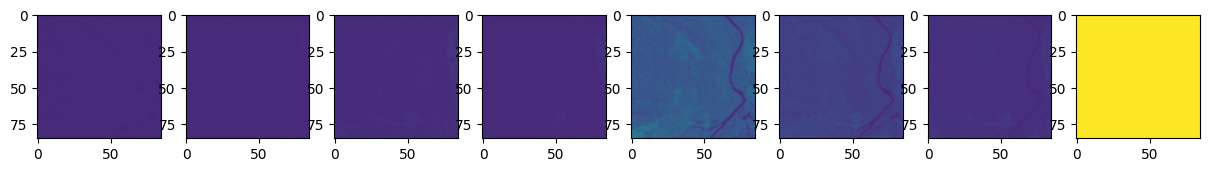

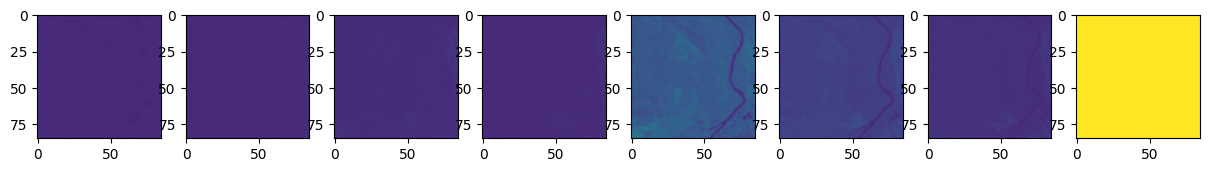

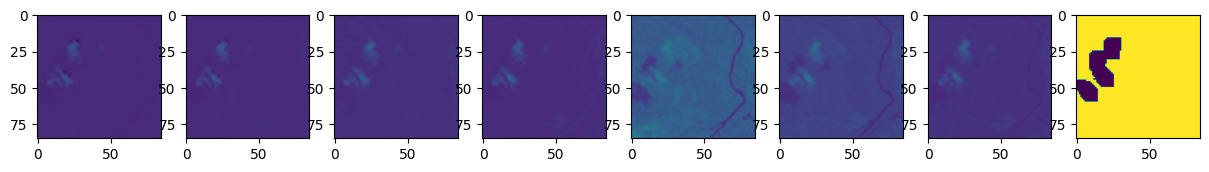

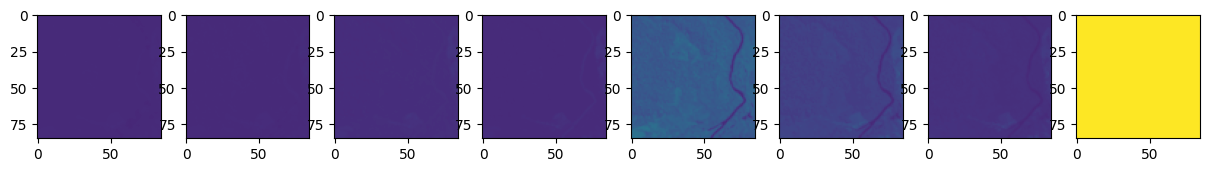

In [8]:
# Get the entries with lat = -3.33 and lon = -54.48
lr = landsat_df[(landsat_df["lat"] == -3.33) & (landsat_df["lon"] == -54.48)]

for item in lr.iterrows():
    image = get_image_and_qa(item[1])
    plot_image(image)
    #print(image.min(axis=(0, 1)), image.max(axis=(0, 1)))